In [9]:
import traci
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

In [10]:
# Constants
NUM_PHASES = 4  # Number of traffic light phases
STATE_DIM = 4   # Number of state variables (adjust based on your scenario)
ACTION_DIM = NUM_PHASES  # Number of possible actions (traffic light phases)
GAMMA = 0.9
EPSILON = 0.1
ALPHA = 0.001
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32
NUM_EPISODES = 100
TARGET_UPDATE_FREQ = 10  # Update target network every TARGET_UPDATE_FREQ episodes

# Q-network and target Q-network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(STATE_DIM,)),
    tf.keras.layers.Dense(ACTION_DIM, activation='linear')
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=ALPHA), loss='mse')

target_model = tf.keras.models.clone_model(model)
target_model.set_weights(model.get_weights())

# Replay memory
memory = []

def get_state():
    # Implement logic to get the current state from SUMO
    state = [
        traci.edge.getLastStepHaltingNumber("in"),
        traci.edge.getLastStepHaltingNumber("intramp"),
        traci.edge.getLastStepMeanSpeed("in"),
        traci.edge.getLastStepMeanSpeed("intramp")
    ]
    return np.array(state)

def choose_action(state):
    # Epsilon-greedy policy
    if np.random.rand() < EPSILON:
        return np.random.randint(ACTION_DIM)
    else:
        q_values = model.predict(state.reshape(1, -1))[0]
        return np.argmax(q_values)

def update_q_network():
    if len(memory) < BATCH_SIZE:
        return

    minibatch = np.array(memory)[np.random.choice(len(memory), BATCH_SIZE, replace=False)]

    states = np.vstack(minibatch[:, 0])
    actions = minibatch[:, 1].astype(int)
    rewards = minibatch[:, 2]
    next_states = np.vstack(minibatch[:, 3])
    terminals = minibatch[:, 4]

    q_values = model.predict(states)
    next_q_values = target_model.predict(next_states)

    for i in range(BATCH_SIZE):
        if terminals[i]:
            q_values[i, actions[i]] = rewards[i]
        else:
            q_values[i, actions[i]] = rewards[i] + GAMMA * np.max(next_q_values[i])

    model.fit(states, q_values, epochs=1, verbose=0)

def calculate_reward(state, action, next_state):
    # Custom reward function
    main_road_halting = state[0]
    ramp_halting = state[1]
    main_road_speed = state[2]
    ramp_speed = state[3]

    # Example reward: Minimize halting on both the main road and ramp,
    # and maximize average speed on both roads
    reward = -(main_road_halting + ramp_halting) + main_road_speed + ramp_speed

    return reward

def check_if_done():
    # Termination condition: End the episode after a certain number of simulation steps
    return traci.simulation.getTime() > 1000

# Connect to SUMO
traci.start(["sumo", "-c", "/Users/cheimamezdour/Projects/RLOC-SUMO/mynet.sumocfg"])

episode_rewards = []  # List to store the total rewards obtained in each episode

# Training loop
for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0

    while traci.simulation.getMinExpectedNumber() > 0:
        # Choose action using epsilon-greedy policy
        action = choose_action(state)

        # Apply the chosen action to the traffic light in SUMO
        traci.trafficlight.setPhase("n2", action)

        # Step the simulation
        traci.simulationStep()

        # Obtain the next state
        next_state = get_state()

        # Calculate reward
        reward = calculate_reward(state, action, next_state)

        # Check if the simulation is done
        done = check_if_done()

        # Store the transition in the replay memory
        memory.append((state, action, reward, next_state, done))

        # Update the Q-network
        update_q_network()

        # Update the current state
        state = next_state
        total_reward += reward

        # Check if the episode is done
        if done:
            break

        model.save("trained_traffic_light_model_dql.h5")


    episode_rewards.append(total_reward)  # Append the total reward for the episode to the list

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    # Update target network every TARGET_UPDATE_FREQ episodes
    if episode % TARGET_UPDATE_FREQ == 0:
        target_model.set_weights(model.get_weights())

# Close connection to SUMO
traci.close()

 Retrying in 1 seconds


1/1 [==============================] - 0s 41ms/step


/var/folders/rr/62tz31v139gdkk0h36fmvq240000gn/T/ipykernel_22006/3986002943.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  minibatch = np.array(memory)[np.random.choice(len(memory), BATCH_SIZE, replace=False)]


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 9ms/step
Episode 1, Total Reward: -102225.44593664771
1/1 [==============================] - 0s 9ms/step
Episode 2, Total Reward: -34.12912068965517
1/1 [==============================] - 0s 9ms/step
Episode 3, Total Reward: -37.18086206896551
1/1 [==============================] - 0s 9ms/step
Episode 4, Total Reward: -39.21966379310345
1/1 [==============================] - 0s 9ms/step
Episode 5, Total Reward: -41.24552586206896
1/1 [==============================] - 0s 9ms/step
Episode 6, Total Reward: -43.27138793103448
1/1 [==============================] - 0s 11ms/step
Episode 7, Total Reward: -46.32225
1/1 [==============================] - 0s 8ms/step
Episode 8, Total Reward: -49.375682887063235
1/1 [==============================] - 0s 9ms/step
Episode 9, Total Reward: -51.411874394816124
1/1 [==============================] - 0s 9ms/step
Episode 10, Total Reward: -51.40336021638504
1/1 [==============================] - 0s 8ms/step
Epi

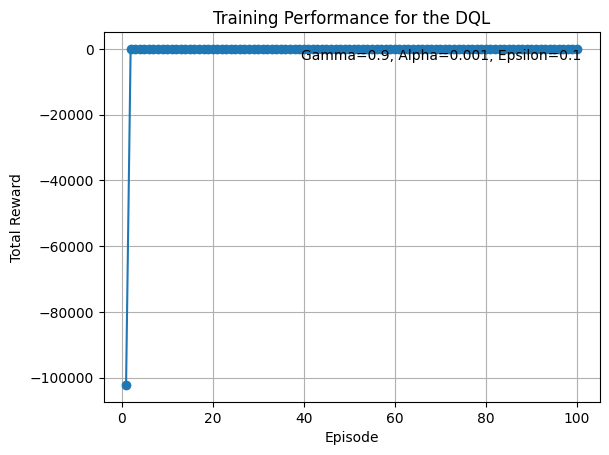

In [12]:
# Plot the episode rewards
plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance for the DQL')
plt.grid(True)

# Add a legend with hyperparameter values
hyperparams_text = f'Gamma={GAMMA}, Alpha={ALPHA}, Epsilon={EPSILON}'
plt.text(NUM_EPISODES + 1, max(episode_rewards), hyperparams_text, ha='right', va='top', fontsize=10)

plt.show()